In [3]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve

from churn_opt.data import load_telco_csv
from churn_opt.features import add_features
from churn_opt.models import build_pipeline

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 5)


In [4]:
df = load_telco_csv("../data/raw/Telco-Customer-Churn.csv")
df = add_features(df)

if "TotalCharges" in df.columns:
    df = df.drop(columns=["TotalCharges"])

train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Churn"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.25, stratify=train_df["Churn"], random_state=42)

X_train = train_df.drop(columns=["Churn"])
y_train = train_df["Churn"].values
X_test  = test_df.drop(columns=["Churn"])
y_test  = test_df["Churn"].values


In [5]:
pipe_lr = build_pipeline(train_df, model_type="lr", random_state=42)
pipe_hgb = build_pipeline(train_df, model_type="hgb", random_state=42)

pipe_lr.fit(X_train, y_train)
pipe_hgb.fit(X_train, y_train)

p_lr = pipe_lr.predict_proba(X_test)[:, 1]
p_hgb = pipe_hgb.predict_proba(X_test)[:, 1]

print("LR AUC:", roc_auc_score(y_test, p_lr))
print("HGB AUC:", roc_auc_score(y_test, p_hgb))

print("LR Brier:", brier_score_loss(y_test, p_lr))
print("HGB Brier:", brier_score_loss(y_test, p_hgb))


LR AUC: 0.8481541760314139
HGB AUC: 0.8230036942313156
LR Brier: 0.16376037255540585
HGB Brier: 0.1479400119780326


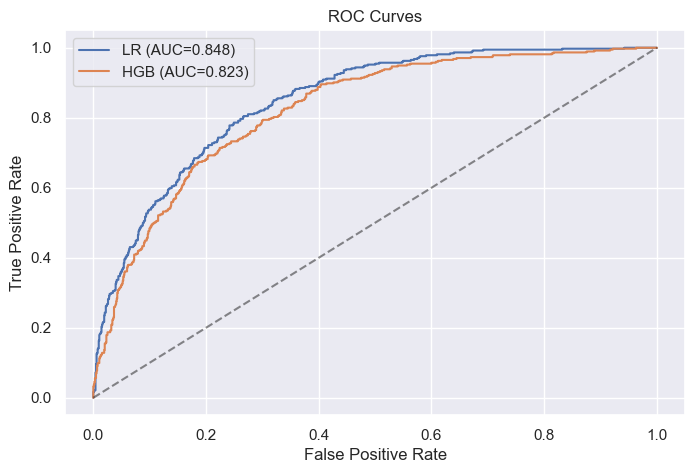

In [6]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, p_lr)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, p_hgb)

plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y_test, p_lr):.3f})")
plt.plot(fpr_hgb, tpr_hgb, label=f"HGB (AUC={roc_auc_score(y_test, p_hgb):.3f})")
plt.plot([0,1], [0,1], "k--", alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


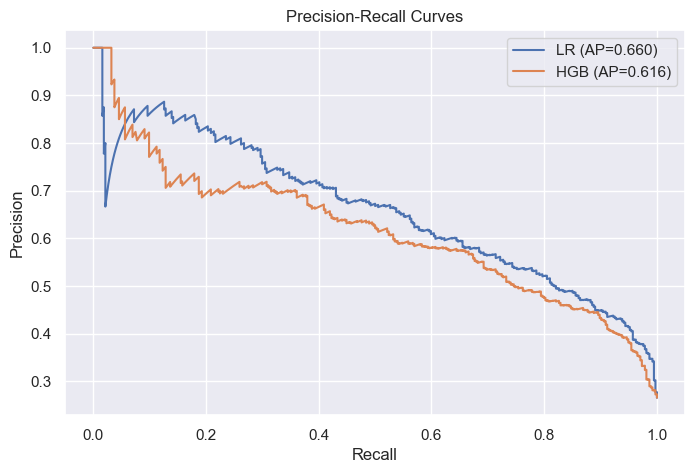

In [7]:
prec_lr, rec_lr, _ = precision_recall_curve(y_test, p_lr)
prec_hgb, rec_hgb, _ = precision_recall_curve(y_test, p_hgb)

plt.plot(rec_lr, prec_lr, label=f"LR (AP={average_precision_score(y_test, p_lr):.3f})")
plt.plot(rec_hgb, prec_hgb, label=f"HGB (AP={average_precision_score(y_test, p_hgb):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


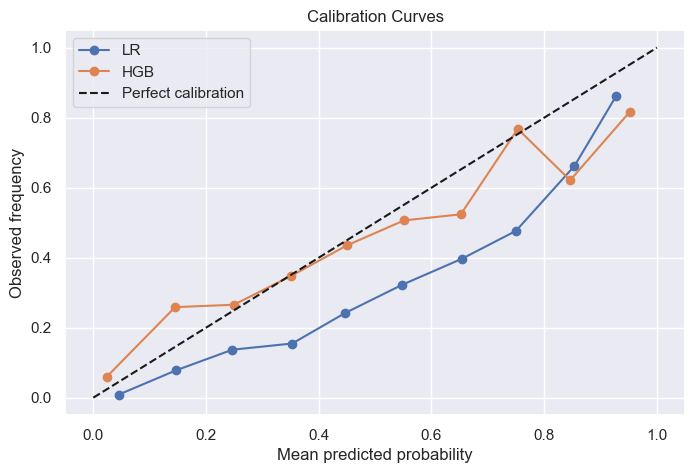

In [8]:
prob_true_lr, prob_pred_lr = calibration_curve(y_test, p_lr, n_bins=10)
prob_true_hgb, prob_pred_hgb = calibration_curve(y_test, p_hgb, n_bins=10)

plt.plot(prob_pred_lr, prob_true_lr, marker="o", label="LR")
plt.plot(prob_pred_hgb, prob_true_hgb, marker="o", label="HGB")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves")
plt.legend()
plt.show()


In [9]:
brier_lr = brier_score_loss(y_test, p_lr)
brier_hgb = brier_score_loss(y_test, p_hgb)

pd.DataFrame({
    "Model": ["Logistic Regression", "HistGradientBoosting"],
    "Brier Score": [brier_lr, brier_hgb]
})


,Model,Brier Score
0,Logistic Regression,0.16376
1,HistGradientBoosting,0.14794


LR has better calibration (closer to diagonal)

LR has better ROC-AUC and PR-AUC

HGB slightly overfits and produces worse probability estimates

Since our business objective depends on probability quality, LR is the better model